In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

In [3]:
import pandas as pd
import numpy as np
from utils import *
from collections import OrderedDict
# from model import *

dep = 'SalePrice'
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/bulldozers-raw')
keep_cols = list(np.load('tmp/keep_cols.npy'))

df_raw.loc[df_raw.YearMade<1950, 'YearMade'] = 1950
df_raw['age'] = df_raw.saleYear-df_raw.YearMade
df_raw = df_raw[keep_cols+['age', dep]].copy()
df_indep = df_raw.drop(dep,axis=1)

n_valid = 12000
n_trn = len(df_raw)-n_valid


cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

for o in ['saleElapsed', 'saleDayofyear', 'saleDay', 'age', 'YearMade']: cat_flds.remove(o)
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]


for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds]

df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, nas, mapper = preprocessing(df_raw, 'SalePrice', do_scale=True)

val_idx = list(range(n_trn, len(df)))

def rmse(x,y): return np.sqrt(((x-y)**2).mean())
from sklearn.metrics import r2_score

# emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c = OrderedDict({n:len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()})
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse, r2_score]

In [4]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)

In [5]:
y_range=(0,np.max(y)*1.2)
m = md.get_learner(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05],
                   y_range=y_range, use_bn=True)

In [5]:
m.lr_find()

A Jupyter Widget

 61%|██████    | 3689/6081 [02:04<01:20, 29.63it/s, loss=0.474] 

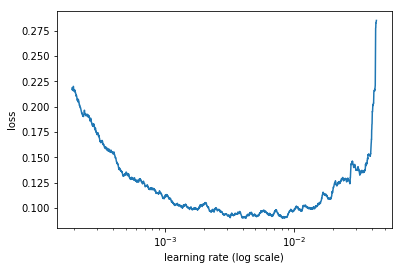

In [6]:
m.sched.plot(1300)

In [6]:
lr=1e-3; wd=1e-7
metrics=[rmse, r2_score]

In [7]:
m.fit(lr, 2, wd, cycle_len=1, cycle_mult=2, metrics=metrics)

A Jupyter Widget

[ 0.       0.06232  0.08863  0.29334 -0.04254]                  
[1.      0.05759 0.08026 0.2786  0.01422]                       
[2.      0.05332 0.06524 0.25152 0.2382 ]                       



In [8]:
m.fit(lr, 2, wd, cycle_len=2, cycle_mult=2, metrics=metrics)

A Jupyter Widget

[0.      0.05291 0.05726 0.23614 0.24813]                       
[1.      0.04679 0.05684 0.23505 0.27703]                       
[2.      0.05261 0.05892 0.23926 0.13341]                       
[3.      0.04924 0.05448 0.23035 0.26257]                       
[4.      0.0451  0.06453 0.24995 0.05277]                       
[5.      0.04401 0.06427 0.24958 0.03127]                       



In [29]:
np.sqrt(0.06427)

0.25351528553521185

In [17]:
m.model.embs

ModuleList(
  (0): Embedding(3, 2)
  (1): Embedding(7, 4)
  (2): Embedding(75, 38)
  (3): Embedding(4, 2)
  (4): Embedding(5219, 50)
  (5): Embedding(176, 50)
  (6): Embedding(7, 4)
  (7): Embedding(5000, 50)
  (8): Embedding(140, 50)
  (9): Embedding(7, 4)
  (10): Embedding(18, 9)
  (11): Embedding(5, 3)
  (12): Embedding(7, 4)
  (13): Embedding(13, 7)
  (14): Embedding(54, 27)
  (15): Embedding(3, 2)
)

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

layer_lookup = dict(zip(emb_c.keys(), m.model.embs))

def plot_embeddings(model, col, pca=True):   
    layer_num = list(layer_lookup.keys()).index(col)
    layer = m.model.embs[layer_num]
    all_values = dict(zip(df_raw[col], df_raw[col].cat.codes))  
    if pca: 
        Z = PCA(n_components=2, random_state=0)
    else:
        Z = TSNE(init='pca', random_state=0, method='exact')
        
    Y = Z.fit_transform(layer.weight.data)       
    plt.figure(figsize=(20,20))
    plt.scatter(Y[:, 0], Y[:, 1])
    for i, txt in enumerate(all_values):
        plt.annotate(txt, (Y[i, 0],Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

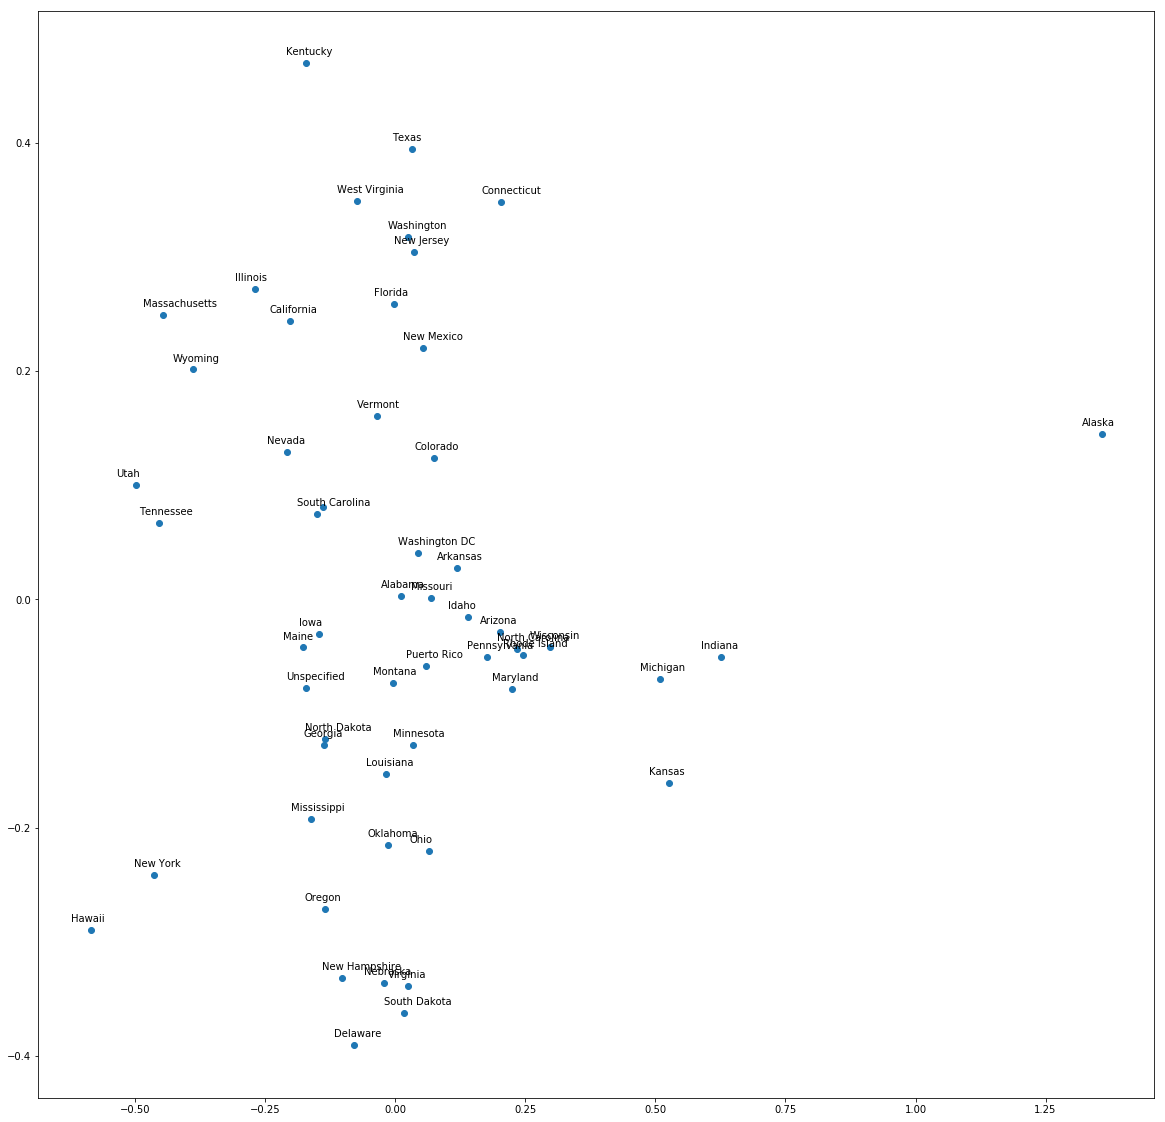

In [27]:
plot_embeddings(m, 'state', pca=True)

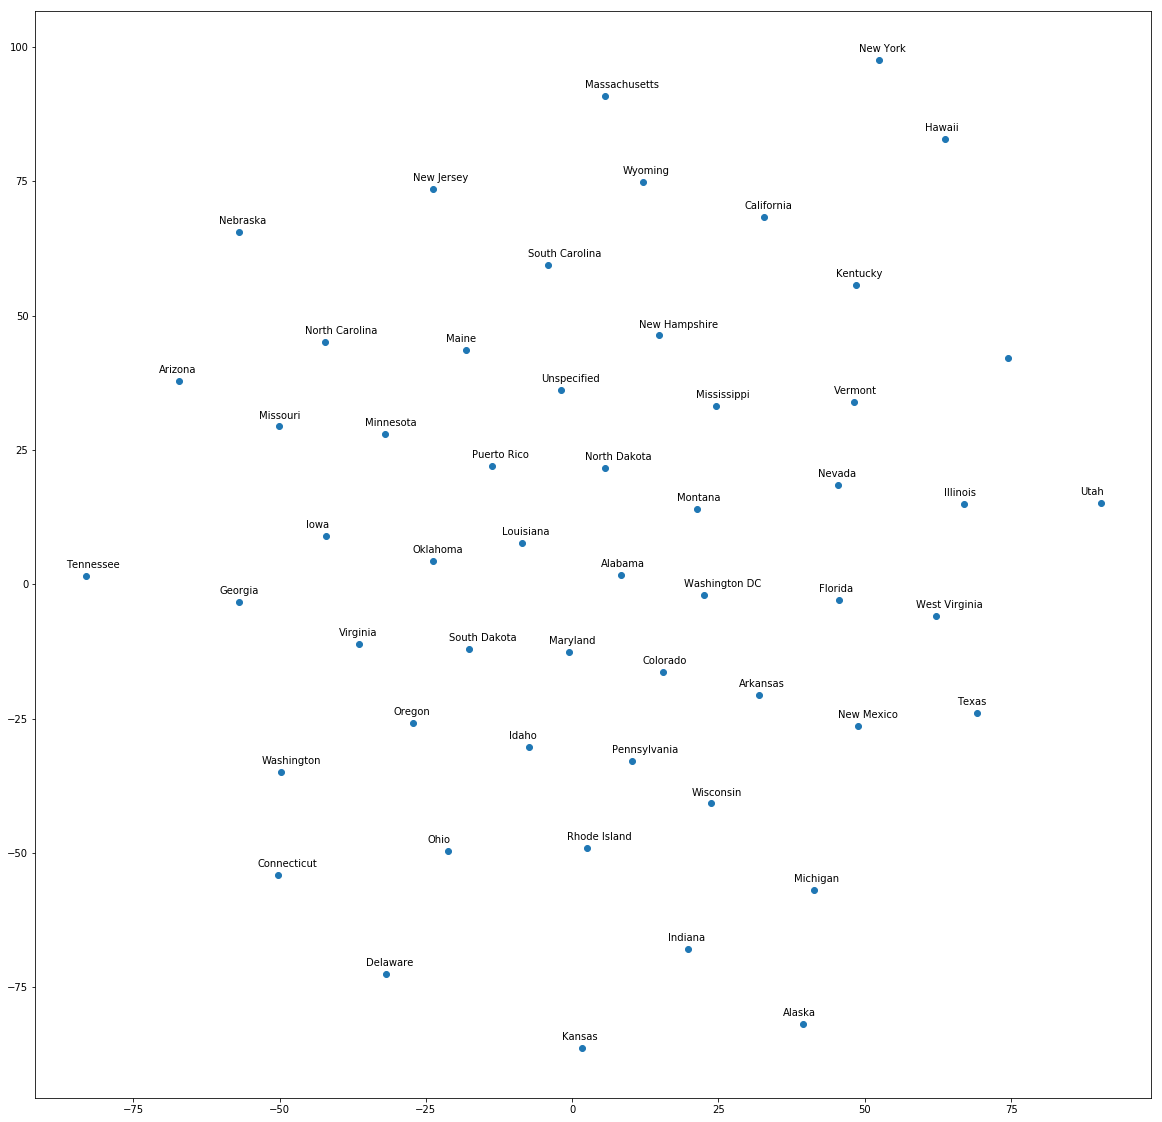

In [28]:
plot_embeddings(m, 'state', pca=False)

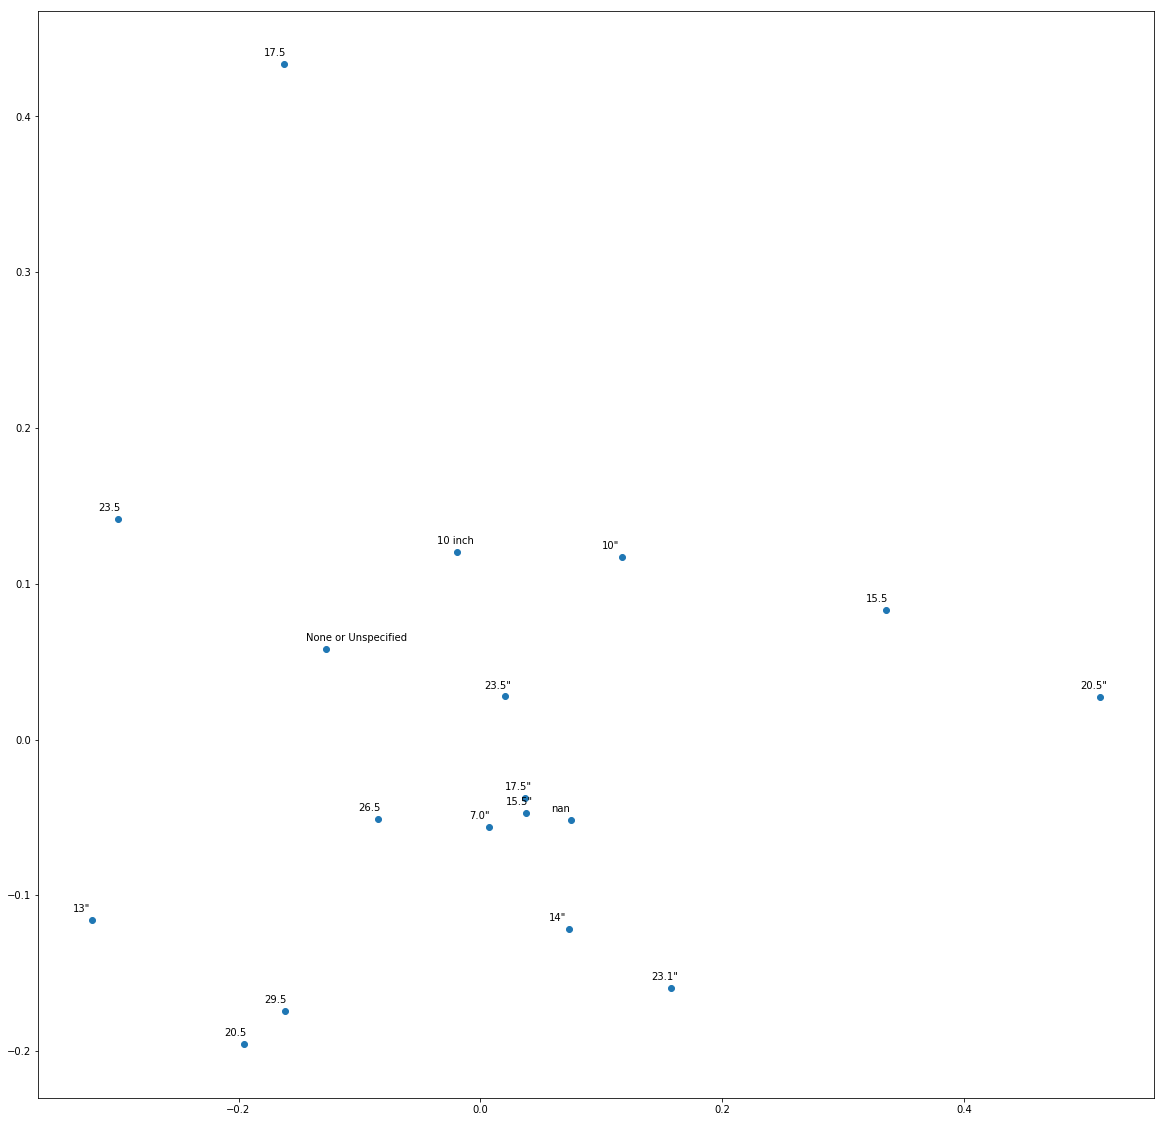

In [35]:
plot_embeddings(m, 'Tire_Size', pca=True)

In [30]:
layer_lookup

{'Coupler_System': Embedding(3, 2),
 'Drive_System': Embedding(5, 3),
 'Enclosure': Embedding(7, 4),
 'Hydraulics': Embedding(13, 7),
 'Hydraulics_Flow': Embedding(4, 2),
 'ModelID': Embedding(5219, 50),
 'ProductGroup': Embedding(7, 4),
 'ProductGroupDesc': Embedding(7, 4),
 'ProductSize': Embedding(7, 4),
 'Tire_Size': Embedding(18, 9),
 'Track_Type': Embedding(3, 2),
 'fiModelDesc': Embedding(5000, 50),
 'fiModelDescriptor': Embedding(140, 50),
 'fiProductClassDesc': Embedding(75, 38),
 'fiSecondaryDesc': Embedding(176, 50),
 'state': Embedding(54, 27)}